Initial shape of the dataset:  (10407, 4)
Reading images from /home/derrickle/Documents/RMIT/ML_Machine_Learning/Group_Project/Rice-Plant-Disease-Classification-/Dataset/train_images
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/10407 [00:00<?, ?it/s]

  0%|          | 0/10407 [00:00<?, ?it/s]

Issue checks completed. 379 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


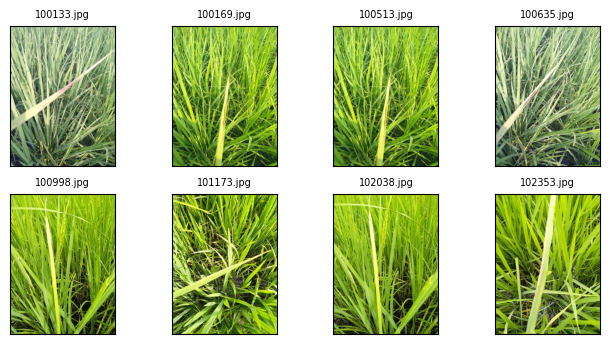

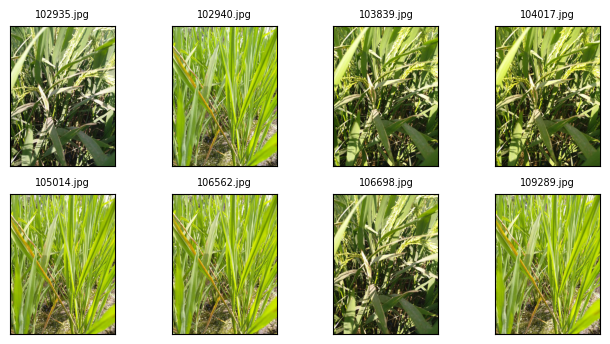

different metadata
different metadata
Final shape of the dataset:  (10206, 4)


In [1]:
from enum import Enum
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import numpy as np
from cleanvision import Imagelab
from cv2.typing import MatLike

df = pd.read_csv("Dataset/meta_train.csv")

print("Initial shape of the dataset: ", df.shape)

imagelab = Imagelab(data_path="Dataset/train_images")
imagelab.find_issues()

imagelab.info["statistics"]["aspect_ratio"]

imagelab.info["statistics"]["size"]

imagelab.issue_summary

exact_duplicate = imagelab.issues[
    imagelab.issues["is_exact_duplicates_issue"]
].index.tolist()
near_duplicate = imagelab.issues[
    imagelab.issues["is_near_duplicates_issue"]
].index.tolist()
imagelab.visualize(image_files=exact_duplicate[:8])
imagelab.visualize(image_files=near_duplicate[:8])

unreliable_sets = []

for set in imagelab.info["exact_duplicates"]["sets"]:
    image_1, image_2 = [set[0].split("/")[-1], set[1].split("/")[-1]]
    meta_1 = (
        df[df["image_id"] == image_1].reset_index().drop(["image_id", "index"], axis=1)
    )
    meta_2 = (
        df[df["image_id"] == image_2].reset_index().drop(["image_id", "index"], axis=1)
    )
    # if comparision has value
    if not meta_1.compare(meta_2).empty:
        unreliable_sets.append(set)
        print("different metadata")

for set in imagelab.info["near_duplicates"]["sets"]:
    image_1, image_2 = [set[0].split("/")[-1], set[1].split("/")[-1]]
    meta_1 = (
        df[df["image_id"] == image_1].reset_index().drop(["image_id", "index"], axis=1)
    )
    meta_2 = (
        df[df["image_id"] == image_2].reset_index().drop(["image_id", "index"], axis=1)
    )
    # if comparision has value
    if not meta_1.compare(meta_2).empty:
        unreliable_sets.append(set)
        print("different metadata")

for set in imagelab.info["exact_duplicates"]["sets"]:
    for i in range(len(set)):
        if i != 0:
            df = df[df["image_id"] != set[i].split("/")[-1]]

for set in imagelab.info["near_duplicates"]["sets"]:
    for i in range(len(set)):
        if i != 0:
            df = df[df["image_id"] != set[i].split("/")[-1]]

for set in unreliable_sets:
    for i in range(len(set)):
        df = df[df["image_id"] != set[i].split("/")[-1]]
        
print("Final shape of the dataset: ", df.shape)


=== Training Configuration ===
Batch size: 23
Input size: (480, 320)
Classes: 10
GPU Memory: 24GB

Model input shape: (None, 320, 480, 3)


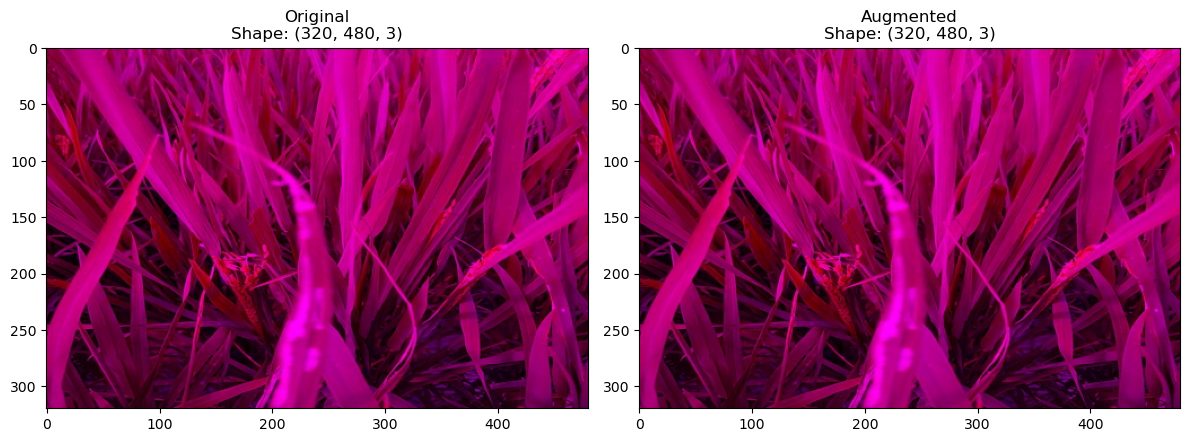

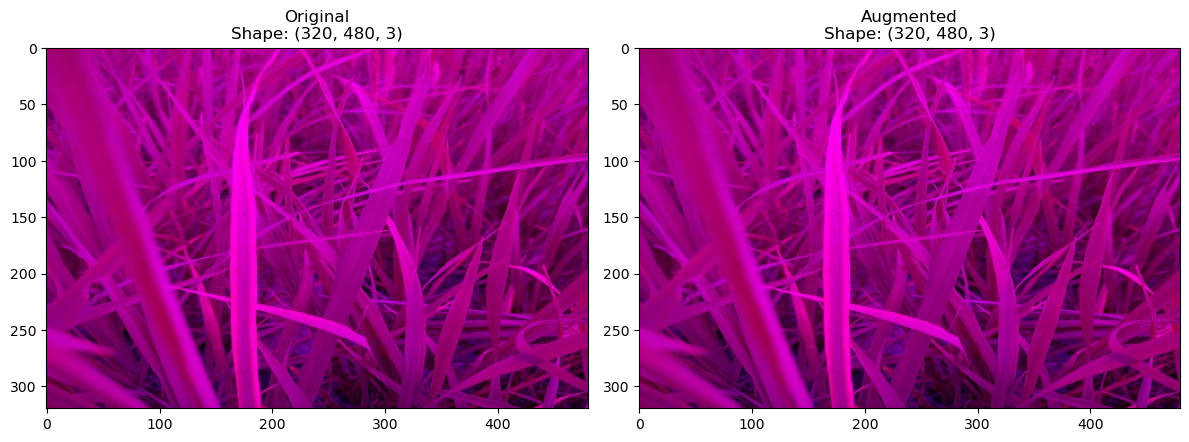

Generator output shape: (32, 320, 480, 3)
Model input shape: (None, 320, 480, 3)
Epoch 1/100


KeyboardInterrupt: 

In [4]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, 
                                   BatchNormalization, Input, GlobalAveragePooling2D, 
                                   Concatenate)
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
import numpy as np
import os
import cv2
import albumentations as A
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# === Configuration ===
config = {
    "data_path": "Dataset/preprocessed_images",
    "csv_path": "processed_data/cleaned_metadata.csv",
    "target_size": (480, 320),  # 3:2 ratio
    "epochs": 100,
    "initial_lr": 0.001,
    "gpu_memory_limit": 24,  # GB
    "batch_size": 32,
}

# === GPU Setup ===
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Enable mixed precision
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        
        # Memory growth and optimization
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.optimizer.set_jit(True)
        tf.config.threading.set_intra_op_parallelism_threads(8)
        tf.config.threading.set_inter_op_parallelism_threads(4)
    except RuntimeError as e:
        print(e)

# === Model Architecture ===
def create_gpu_optimized_model(input_shape, num_classes):
    inputs = Input(shape=input_shape, dtype=tf.float16)
    
    # Initial feature extraction
    x = Conv2D(96, (7,7), strides=2, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3), strides=2)(x)
    
    # Intermediate layers
    x = Conv2D(256, (5,5), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3), strides=2)(x)
    
    # Parallel paths
    branch1 = Conv2D(384, (3,3), activation='relu', padding='same')(x)
    branch2 = Conv2D(384, (3,3), dilation_rate=2, activation='relu', padding='same')(x)
    x = Concatenate()([branch1, branch2])
    
    # Final classification head
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', name='features')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', dtype=tf.float32)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# === Memory Management ===
def calculate_max_batch_size(model, input_shape=(480, 320, 3), gpu_mem=24):
    """Improved batch size calculator"""
    try:
        # Estimate memory usage per sample
        params = model.count_params()
        
        # Find last dense layer
        last_dense = next(layer for layer in reversed(model.layers) 
                     if isinstance(layer, Dense) and layer.name == 'features')
        
        # Memory estimation (conservative)
        per_sample = (params * 4 +  # 4 bytes per parameter
                     np.prod(input_shape) * last_dense.units * 4) / (1024**3)  # GB
        
        # Calculate max batch with 3GB buffer
        max_batch = int((gpu_mem - 3) / per_sample)
        
        return max(16, min(256, max_batch))
    
    except Exception as e:
        print(f"Error calculating batch size: {e}")
        return 32  # Fallback value

def cleanup_gpu_memory():
    """Force clear GPU memory"""
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    if tf.config.list_physical_devices('GPU'):
        try:
            for gpu in tf.config.list_physical_devices('GPU'):
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError:
            pass

# === Data Pipeline ===
from sklearn.model_selection import train_test_split
def load_and_preprocess_data():
    df = pd.read_csv(config["csv_path"])
    
    # Label encoding
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['label'])
    
    # Train-val split
    train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['label'])
    
    return train_df, val_df, le

class RiceDataGenerator(Sequence):
    def __init__(self, df, base_path, batch_size=32, target_size=(480, 320), shuffle=True, debug=False, **kwargs):
        super().__init__(**kwargs)
        self.df = df.reset_index(drop=True)
        self.base_path = base_path
        self.batch_size = batch_size
        self.target_size = target_size  
        self.shuffle = shuffle
        self.debug = debug
        self.indices = np.arange(len(df))
        
        self.aug = A.Compose([
            # A.RandomRotate90(),
            # A.HorizontalFlip(),
            # A.VerticalFlip(),
            # A.Transpose(),
            # A.RandomBrightnessContrast(p=0.5),
            # A.HueSaturationValue(p=0.5),
            # A.CLAHE(p=0.5),
            A.Resize(width=self.target_size[0], height=self.target_size[1]),
        ])
        
        if shuffle:
            np.random.shuffle(self.indices)
            
        if self.debug:
            self._visualize_samples()    
            

    def _visualize_samples(self):
        """Visualize first 2 samples after augmentation"""
        import matplotlib.pyplot as plt
        
        for i in range(min(2, len(self.df))):
            try:
                row = self.df.iloc[i]
                img = self._load_image(row['image_id'], row['label'])
                augmented = self.aug(image=img)
                
                plt.figure(figsize=(12, 6))
                
                # Show original
                plt.subplot(1, 2, 1)
                plt.imshow(img)
                plt.title(f"Original\nShape: {img.shape}")
                
                # Show augmented
                plt.subplot(1, 2, 2)
                plt.imshow(augmented['image'])
                plt.title(f"Augmented\nShape: {augmented['image'].shape}")
                
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"Visualization failed for {row['image_id']}: {str(e)}")
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    @property
    def num_batches(self):
        return len(self)
    
    def _load_image(self, image_id, label, suffix='green'):
        img_path = os.path.join(
            self.base_path,
            label,
            f"{os.path.splitext(image_id)[0]}_{suffix}.jpg"
        )
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found at {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize using (width, height)
        img = cv2.resize(img, self.target_size)  
        return img
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        # Initialize with correct dimensions (height, width, channels)
        X = np.zeros((len(batch_df), self.target_size[1], self.target_size[0], 3), dtype=np.float32)
        y = np.zeros((len(batch_df),), dtype=np.int32)
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            try:
                img = self._load_image(row['image_id'], row['label'])
                # No need to transpose - we'll match model to data shape
                augmented = self.aug(image=img)
                X[i] = augmented['image'] / 255.0
                y[i] = row['label_encoded']
            except Exception as e:
                print(f"Error loading {row['image_id']}: {str(e)}")
                X[i] = np.zeros((self.target_size[1], self.target_size[0], 3), dtype=np.float32)
                y[i] = -1
                
        valid = y != -1
        return X[valid], y[valid]

    def on_epoch_end(self):
        """Shuffle indices after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indices)

from tensorflow.keras.optimizers import AdamW
# === Training ===
def train():
    cleanup_gpu_memory()
    
    try:
        # Load data
        train_df, val_df, le = load_and_preprocess_data()
        num_classes = len(le.classes_)
        
        # Create model
        input_shape = (320, 480, 3)  # (height, width, channels)
        model = create_gpu_optimized_model(input_shape, num_classes)

        
        # Calculate batch size
        cleanup_gpu_memory()
        batch_size = calculate_max_batch_size(model)
        print(f"\n=== Training Configuration ===")
        print(f"Batch size: {batch_size}")
        print(f"Input size: {config['target_size']}")
        print(f"Classes: {num_classes}")
        print(f"GPU Memory: {config['gpu_memory_limit']}GB\n")
        
        # Test the generator
        # test_gen = RiceDataGenerator(
        #     df=train_df[:100],
        #     base_path=config["data_path"],
        #     batch_size=10
        # )
        # test_img, _ = test_gen[0]
        # print(f"Test image shape: {test_img.shape}") 
        # model.fit(test_gen, epochs=1)  # Test run

        # Should match your model's input shape:
        print(f"Model input shape: {model.input_shape}")
        
        if True:
            
            # Create generators
            train_gen = RiceDataGenerator(
                df=train_df,
                base_path=config["data_path"],
                batch_size=config["batch_size"],
                target_size=config["target_size"],
                debug=True,
                shuffle=True
            )
            
            val_gen = RiceDataGenerator(
                df=val_df,
                base_path=config["data_path"],
                batch_size=config["batch_size"],
                target_size=config["target_size"],
                shuffle=False
            )
            
            input_shape = (config["target_size"][1], config["target_size"][0], 3)  # (height, width, channels)
            model = create_gpu_optimized_model(input_shape, len(le.classes_))
            
            # Compile the model
            model.compile(
                optimizer=AdamW(learning_rate=config["initial_lr"], weight_decay=1e-4),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )
            
            # Verify shapes
            sample_batch = train_gen[0]
            print(f"Generator output shape: {sample_batch[0].shape}")
            print(f"Model input shape: {model.input_shape}")
            
            # Train
            history = model.fit(
                train_gen,
                validation_data=val_gen,
                epochs=config["epochs"],
                callbacks=[
                    tf.keras.callbacks.EarlyStopping(patience=10),
                    tf.keras.callbacks.ModelCheckpoint('best_model.h5')
                ]
            )

            
            # # Add this right after generator creation
            # print("\n=== Data Pipeline Verification ===")
            # print(f"Training samples: {len(train_gen.df)}")
            # print(f"Validation samples: {len(val_gen.df)}")

            # # Inspect a batch
            # x_batch, y_batch = train_gen[0]
            # print("\nTraining batch:")
            # print(f"Images shape: {x_batch.shape} (should be (batch, 320, 480, 3))")
            # print(f"Labels shape: {y_batch.shape}")
            # print(f"Unique labels: {np.unique(y_batch)}")

            # x_val, y_val = val_gen[0]
            # print("\nValidation batch:")
            # print(f"Images shape: {x_val.shape}")
            # print(f"Labels shape: {y_val.shape}")
            # print(f"Unique labels: {np.unique(y_val)}")
            
            # # Compile
            # model.compile(
            #     optimizer=tf.keras.optimizers.AdamW(learning_rate=config["initial_lr"], weight_decay=1e-4),
            #     loss='sparse_categorical_crossentropy',
            #     metrics=['accuracy',
            #             tf.keras.metrics.AUC(name='auc'),
            #             tf.keras.metrics.Precision(name='precision'),
            #             tf.keras.metrics.Recall(name='recall')]
            # )
            
            # print("\n=== Model Verification ===")
            # print(f"Model input shape: {model.input_shape} (should be (None, 320, 480, 3))")
            # print(f"Model output shape: {model.output_shape} (should match your classes)")
            # model.summary()
            
            # # Callbacks
            # callbacks = [
            #     tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            #     tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3),
            #     tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
            #     tf.keras.callbacks.TensorBoard(log_dir='./logs')
            # ]
            
            # # Train
            # history = model.fit(
            #     train_gen,
            #     validation_data=val_gen,
            #     epochs=config["epochs"],
            #     callbacks=callbacks,
            #     verbose=1
            # )
        
            return model, history
        
        return model, history
        
    except Exception as e:
        print(f"Training failed: {e}")
        cleanup_gpu_memory()
        raise

# === Execution ===
if __name__ == "__main__":
    model, history = train()